# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

---
## 2. Load data

In [28]:
df = pd.read_csv('../TASK 2/clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
df = df.drop(columns='Unnamed: 0', axis=1)

In [29]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2013-06-15,2015-11-01,2015-06-23,0.00,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2009-08-21,2009-08-21,2015-08-31,189.95,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,4,544,0,0,2010-04-16,2010-04-16,2010-04-16,2015-04-17,47.96,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14605 entries, 0 to 14604
Data columns (total 53 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14605 non-null  object        
 1   channel_sales                   14605 non-null  int64         
 2   cons_12m                        14605 non-null  int64         
 3   cons_gas_12m                    14605 non-null  int64         
 4   cons_last_month                 14605 non-null  int64         
 5   date_activ                      14605 non-null  datetime64[ns]
 6   date_end                        14605 non-null  datetime64[ns]
 7   date_modif_prod                 14605 non-null  datetime64[ns]
 8   date_renewal                    14605 non-null  datetime64[ns]
 9   forecast_cons_12m               14605 non-null  float64       
 10  forecast_cons_year              14605 non-null  int64         
 11  fo

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [31]:
price_df = pd.read_csv('../TASK 2/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [52]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean', 'price_mid_peak_var': 'mean',
                                                                   'price_mid_peak_fix':'mean', 'price_peak_var':'mean', 'price_peak_fix':'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2','price_mid_peak_var': 'dec_3',
                                           'price_mid_peak_fix':'dec_4', 'price_peak_var':'dec_5', 'price_peak_fix':'dec_6' }), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_jan_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_jan_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff['midpeak_diff_dec_jan_energy'] = diff['dec_3'] - diff['price_mid_peak_var']
diff['midpeak_diff_dec_jan_power'] = diff['dec_4'] - diff['price_off_peak_fix']
diff['peak_diff_dec_jan_energy'] = diff['dec_5'] - diff['price_peak_var']
diff['peak_diff_dec_jan_power'] = diff['dec_6'] - diff['price_peak_fix']

diff = diff[['id', 'offpeak_diff_dec_jan_energy','offpeak_diff_dec_jan_power', 'midpeak_diff_dec_jan_energy', 'midpeak_diff_dec_jan_power',
             'peak_diff_dec_jan_energy', 'peak_diff_dec_jan_power' ]]
diff.head()

,id,offpeak_diff_dec_jan_energy,offpeak_diff_dec_jan_power,midpeak_diff_dec_jan_energy,midpeak_diff_dec_jan_power,peak_diff_dec_jan_energy,peak_diff_dec_jan_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,0.003487,-24.274414,-0.002302,0.097749
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,-44.266931,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0.000000,-44.444710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,0.000763,-24.274414,-0.005120,0.097749
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0.000000,-44.266931,0.000000,0.000000


### Difference between off-peak prices in December and preceding June

In [53]:
# Get june prices
jun_prices = monthly_price_by_id.groupby('id').nth(5).reset_index()

# Calculate the difference with respect to december
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2','price_mid_peak_var': 'dec_3',
                                           'price_mid_peak_fix':'dec_4', 'price_peak_var':'dec_5', 'price_peak_fix':'dec_6'}), jun_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_jun_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_jun_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff['midpeak_diff_dec_jun_energy'] = diff['dec_3'] - diff['price_mid_peak_var']
diff['midpeak_diff_dec_jun_power'] = diff['dec_4'] - diff['price_off_peak_fix']
diff['peak_diff_dec_jun_energy'] = diff['dec_5'] - diff['price_peak_var']
diff['peak_diff_dec_jun_power'] = diff['dec_6'] - diff['price_peak_fix']

diff = diff[['id', 'offpeak_diff_dec_jun_energy','offpeak_diff_dec_jun_power', 'midpeak_diff_dec_jun_energy', 'midpeak_diff_dec_jun_power',
             'peak_diff_dec_jun_energy', 'peak_diff_dec_jun_power' ]]
diff.head()

,id,offpeak_diff_dec_jun_energy,offpeak_diff_dec_jun_power,midpeak_diff_dec_jun_energy,midpeak_diff_dec_jun_power,peak_diff_dec_jun_energy,peak_diff_dec_jun_power
0,0002203ffbb812588b632b9e628cc38d,-0.008161,0.000000,-0.000054,-24.437330,-0.004169,0.000000
1,0004351ebdd665e6ee664792efc4fd13,-0.004462,0.000000,0.000000,-44.444710,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,-0.004462,0.000000,0.000000,-45.944710,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162912,0.000763,-24.274418,-0.005120,0.097752
4,00114d74e963e47177db89bc70108537,-0.004462,0.000000,0.000000,-44.266930,0.000000,0.000000


### Difference between off-peak prices in December and preceding Septemebr

In [54]:
# Get september prices
sep_prices = monthly_price_by_id.groupby('id').nth(8).reset_index()

# Calculate the difference with respect to december prices
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2','price_mid_peak_var': 'dec_3',
                                           'price_mid_peak_fix':'dec_4', 'price_peak_var':'dec_5', 'price_peak_fix':'dec_6'}), sep_prices.drop(columns='price_date'), on='id')

diff['offpeak_diff_dec_sep_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_sep_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff['midpeak_diff_dec_sep_energy'] = diff['dec_3'] - diff['price_mid_peak_var']
diff['midpeak_diff_dec_sep_power'] = diff['dec_4'] - diff['price_off_peak_fix']
diff['peak_diff_dec_sep_energy'] = diff['dec_5'] - diff['price_peak_var']
diff['peak_diff_dec_sep_power'] = diff['dec_6'] - diff['price_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_sep_energy','offpeak_diff_dec_sep_power', 'midpeak_diff_dec_sep_energy', 'midpeak_diff_dec_sep_power',
             'peak_diff_dec_sep_energy', 'peak_diff_dec_sep_power' ]]
diff.head()

,id,offpeak_diff_dec_sep_energy,offpeak_diff_dec_sep_power,midpeak_diff_dec_sep_energy,midpeak_diff_dec_sep_power,peak_diff_dec_sep_energy,peak_diff_dec_sep_power
0,0002203ffbb812588b632b9e628cc38d,0.0,0.0,0.0,-24.43733,0.0,0.0
1,0004351ebdd665e6ee664792efc4fd13,0.0,0.0,0.0,-44.44471,0.0,0.0
2,0010bcc39e42b3c2131ed2ce55246e3c,0.0,0.0,0.0,-45.94471,0.0,0.0
3,0010ee3855fdea87602a5b7aba8e42de,0.0,0.0,0.0,-24.43733,0.0,0.0
4,00114d74e963e47177db89bc70108537,0.0,0.0,0.0,-44.26693,0.0,0.0


### Mean difference in consecutive months

In [56]:
# Calculate the difference between consecutive rows for selected columns
selected_columns = ['price_off_peak_var', 'price_off_peak_fix', 'price_mid_peak_var','price_mid_peak_fix', 'price_peak_var', 'price_peak_fix']  # Add other columns as needed
diff_between_months = monthly_price_by_id.groupby('id')[selected_columns].diff().fillna(0)

# Calculate the mean difference for each 'id'
mean_diff_between_months = diff_between_months.groupby(monthly_price_by_id['id']).mean().reset_index()

# Rename the columns
mean_diff_between_months = mean_diff_between_months.rename(columns={
    'price_off_peak_var': 'mean_diff_price_off_peak_var',
    'price_off_peak_fix': 'mean_diff_price_off_peak_fix',
    'price_mid_peak_var': 'mean_diff_price_mid_peak_var',
    'price_mid_peak_fix' :'mean_diff_price_mid_peak_fix',
    'price_peak_var' : 'mean_diff_price_peak_var',
    'price_peak_fix' : 'mean_diff_price_peak_fix'
    # Add other columns here if needed
})

mean_diff_between_months.head()

,id,mean_diff_price_off_peak_var,mean_diff_price_off_peak_fix,mean_diff_price_mid_peak_var,mean_diff_price_mid_peak_fix,mean_diff_price_peak_var,mean_diff_price_peak_fix
0,0002203ffbb812588b632b9e628cc38d,-0.000516,1.357630e-02,0.000291,0.005431,-0.000192,0.008146
1,0004351ebdd665e6ee664792efc4fd13,-0.000342,1.481490e-02,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.004204,1.250000e-01,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.000835,1.357630e-02,0.000064,0.005431,-0.000427,0.008146
4,00114d74e963e47177db89bc70108537,-0.000333,-1.000000e-07,0.000000,0.000000,0.000000,0.000000


### Max difference in consecutive months

Here, we get the maximum absolute value for the difference between consecutive months. 

In [57]:
# Calculate the maximum difference for each 'id'
max_diff_between_months = diff_between_months.abs().groupby(monthly_price_by_id['id']).max().reset_index()

# Rename the columns
max_diff_between_months = max_diff_between_months.rename(columns={
    'price_off_peak_var': 'max_diff_price_off_peak_var',
    'price_off_peak_fix': 'max_diff_price_off_peak_fix',
    'price_mid_peak_var': 'max_diff_price_mid_peak_var',
    'price_mid_peak_fix' :'max_diff_price_mid_peak_fix',
    'price_peak_var' : 'max_diff_price_peak_var',
    'price_peak_fix' : 'max_diff_price_peak_fix'
    # Add other columns here if needed
})

max_diff_between_months.head()

,id,max_diff_price_off_peak_var,max_diff_price_off_peak_fix,max_diff_price_mid_peak_var,max_diff_price_mid_peak_fix,max_diff_price_peak_var,max_diff_price_peak_fix
0,0002203ffbb812588b632b9e628cc38d,0.008161,0.162916,0.003541,0.065166,0.004169,0.097749
1,0004351ebdd665e6ee664792efc4fd13,0.004462,0.177779,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.052694,1.500000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,0.008161,0.162912,0.000817,0.065172,0.004169,0.097752
4,00114d74e963e47177db89bc70108537,0.004462,0.000001,0.000000,0.000000,0.000000,0.000000


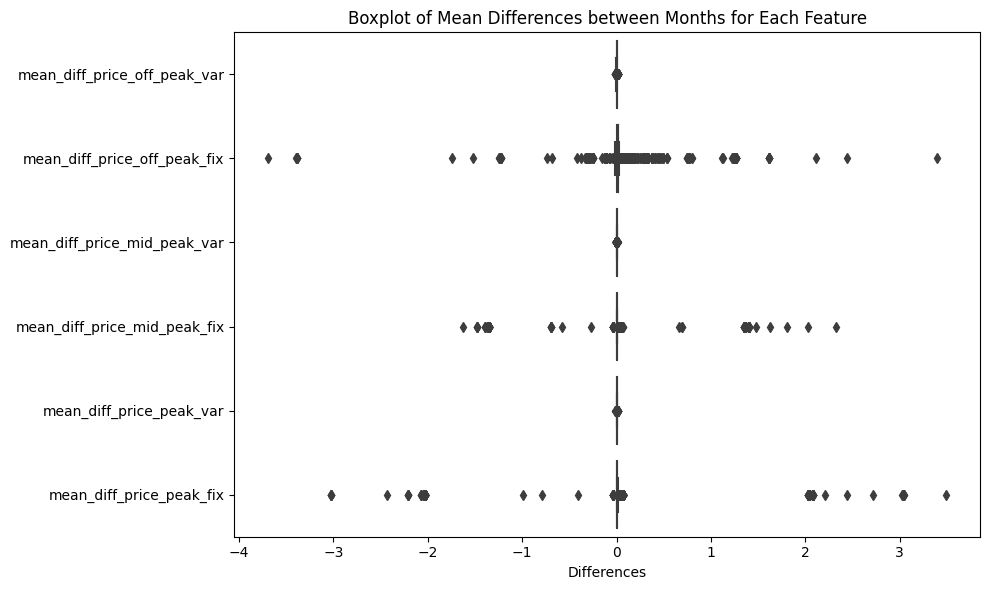

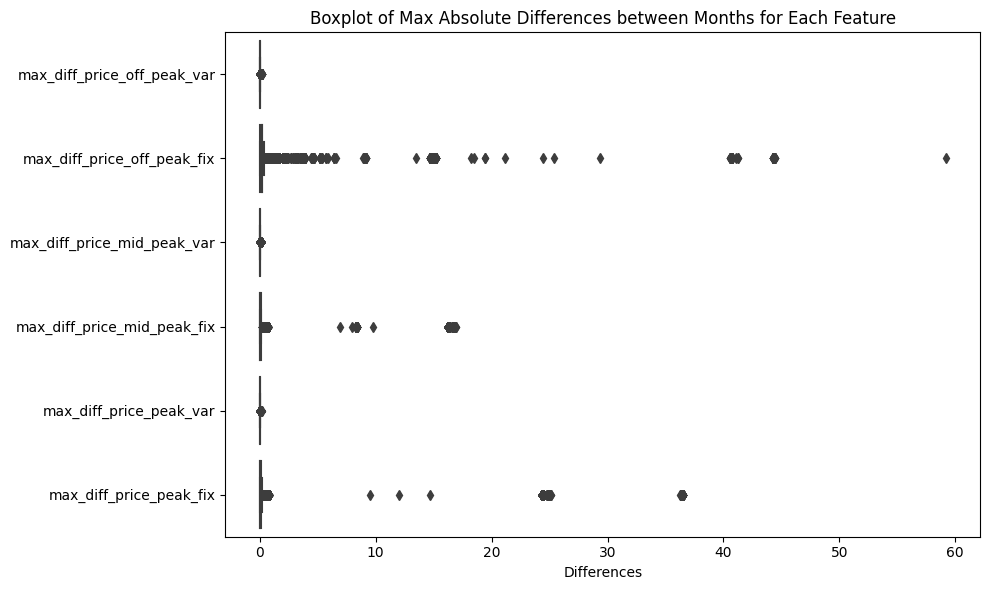

In [58]:

# Boxplot for mean differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=mean_diff_between_months.iloc[:, 1:], orient='h')
plt.xlabel('Differences')
plt.title('Boxplot of Mean Differences between Months for Each Feature')
plt.tight_layout()
plt.show()

# Boxplot for max absolute differences
plt.figure(figsize=(10, 6))
sns.boxplot(data=max_diff_between_months.iloc[:, 1:], orient='h')
plt.xlabel('Differences')
plt.title('Boxplot of Max Absolute Differences between Months for Each Feature')
plt.tight_layout()
plt.show()


### Treating Skewed Data

In [59]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


Using a log10 transformation on energy consumption data that is always positive can be a suitable approach, especially if the data is right-skewed due to outliers. 

### Advantages of Log10 Transformation for Positive Skewed Data:

1. **Outlier Mitigation:** Log transformations can effectively reduce the impact of extreme values or outliers by compressing the scale. This helps in making the distribution more symmetrical.

2. **Normalization:** When the data is right-skewed (with a few very high values), log transformations can help in normalizing the distribution, making it closer to a normal or Gaussian distribution. This can make the data more amenable to certain statistical analyses that assume normality.

3. **Stabilizing Variance:** Applying log transformation can help stabilize variance, especially if the variability in the data increases with the magnitude of the values.



In [62]:

#Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)


df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,0.710011,0.129006,0.421021,0.587675,0.350728,0.966450,0.387016,0.137282,0.050488,43.130085
std,0.092442,0.278673,0.310790,0.108450,0.303840,5.108355,0.117628,0.024623,0.049037,4.486140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.677056,0.000000,0.000000,0.567669,0.000000,0.000000,0.349282,0.116340,0.000000,40.606701
50%,0.711786,0.000000,0.591045,0.607105,0.543858,0.000000,0.361098,0.143166,0.084138,44.311378
75%,0.748985,0.000000,0.656044,0.641554,0.627601,0.000000,0.494248,0.146348,0.098837,44.311378
max,0.891698,0.881871,0.838041,0.772217,0.795461,30.000000,0.577305,0.273963,0.195975,59.266378


/var/folders/zk/6ht630915hxgxw31_05dy9vh0000gn/T/ipykernel_83059/73594896.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
/var/folders/zk/6ht630915hxgxw31_05dy9vh0000gn/T/ipykernel_83059/73594896.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df[df

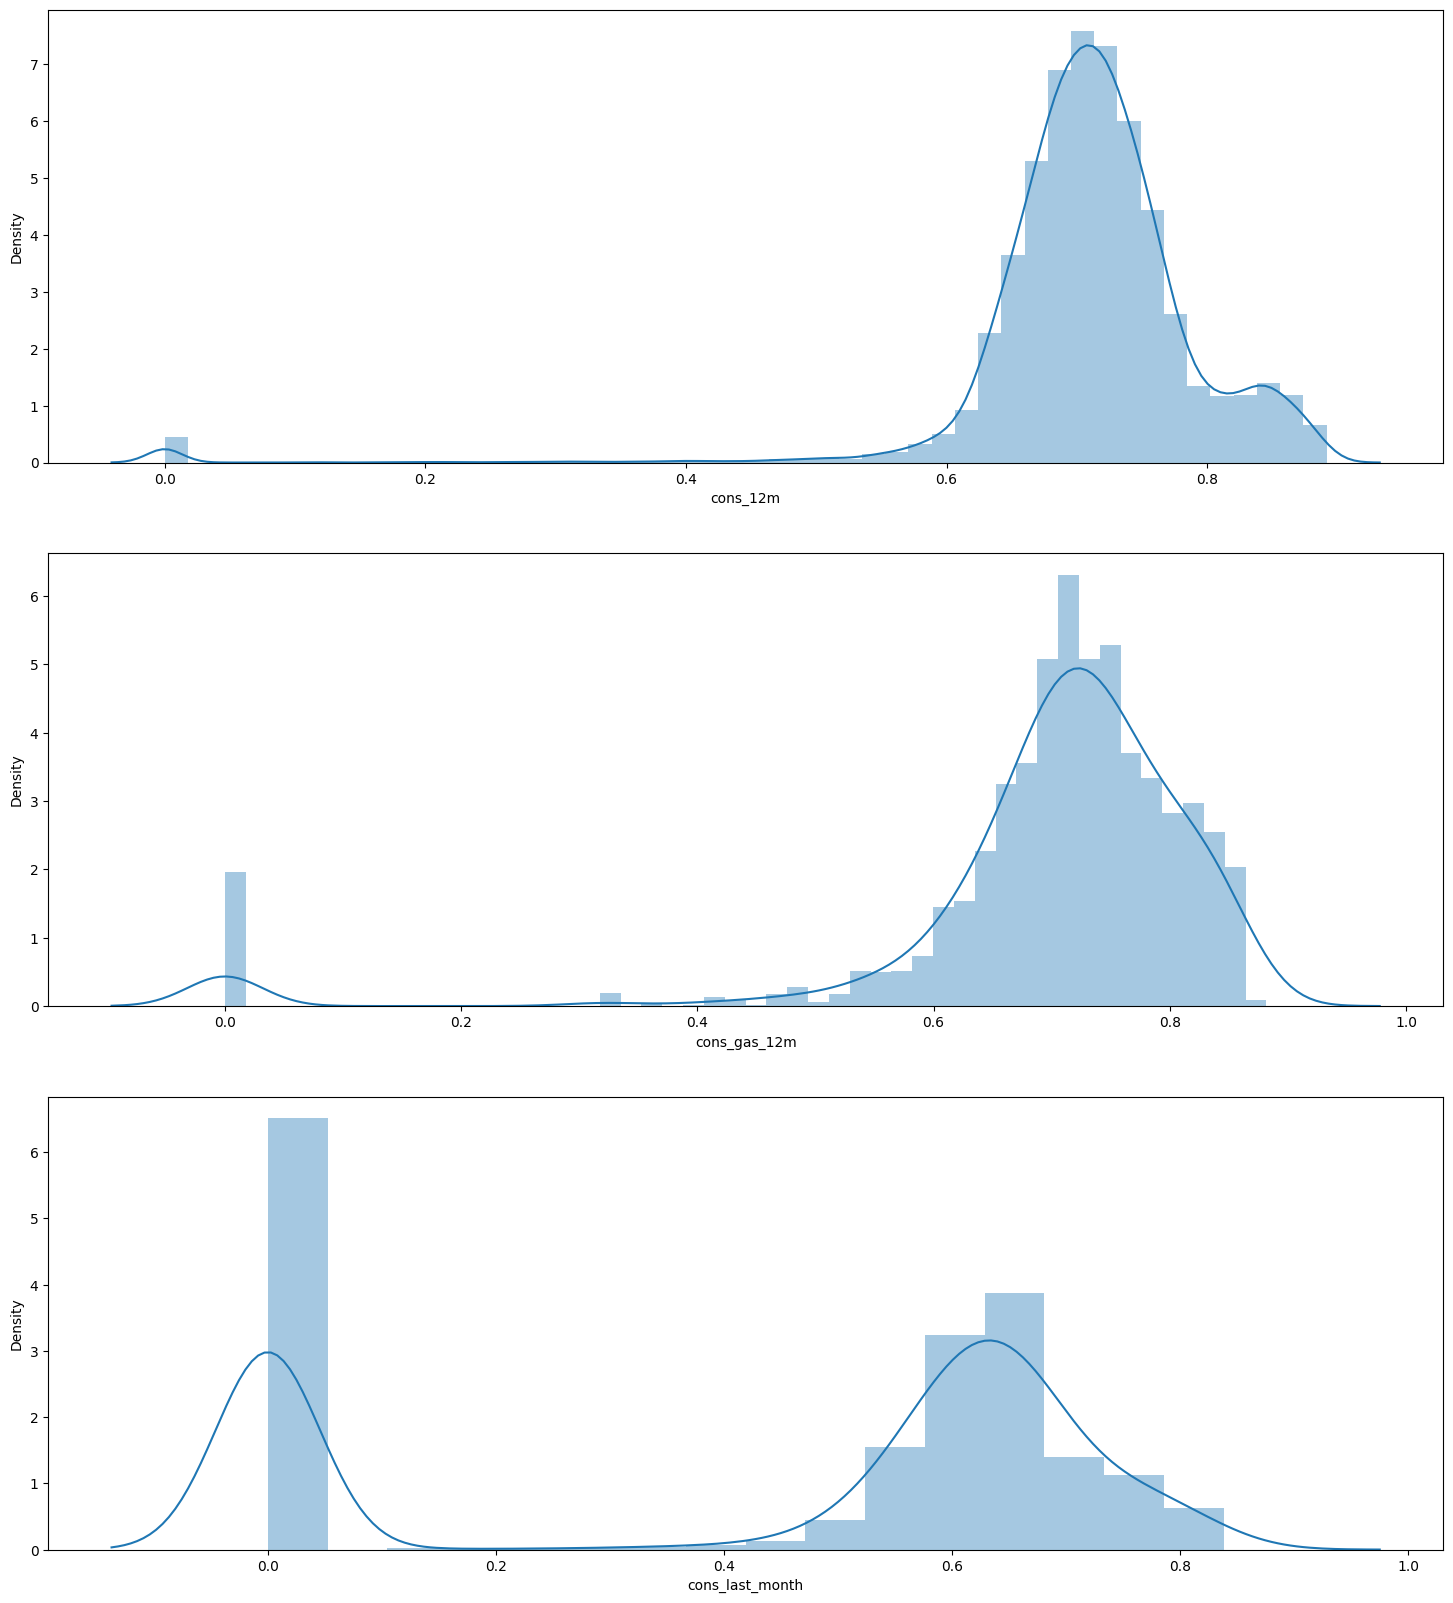

In [63]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()